In [ ]:
#base folder
dataset_path = '/kaggle/input/tf-flowers/flower_photos'
# downloaded from "http://download.tensorflow.org/example_images/flower_photos.tgz"

In [ ]:
# List the directories and files
import os

for folder_name in os.listdir(dataset_path):
    print(folder_name)

In [ ]:
# Create lists to hold image paths and labels
image_paths = []
labels = []

# Iterate through each folder in the dataset
for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    
    if os.path.isdir(label_path):  # Make sure it's a directory
        for file_name in os.listdir(label_path):
            if file_name.endswith(('jpg', 'png', 'jpeg')):  # Assuming you're working with these formats
                image_paths.append(os.path.join(label_path, file_name))
                labels.append(label)

In [ ]:
class_names = list(set(labels))
class_names
n_classes = len(class_names)
n_classes

In [ ]:
#===================== START FROM HERE ============================

In [44]:
#Delete output folders
import shutil
shutil.rmtree("/kaggle/working/split_dataset")

In [178]:
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips',]
n_classes = 5

In [46]:
#Create output directory to create folders for train, validation and test

import os
import shutil
import random

# Define the source and destination directories
source_dir ='/kaggle/input/tf-flowers/flower_photos'
split_dir = 'split_dataset'

# Create directories for train, validation, and test
os.makedirs(os.path.join(split_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(split_dir, 'validation'), exist_ok=True)
os.makedirs(os.path.join(split_dir, 'test'), exist_ok=True)

In [47]:
#copy files to new folders

# Iterate over each class folder
for class_folder in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_folder)
    
    if os.path.isdir(class_path):  # Check if it's a folder
        # Create class directories in split directory
        os.makedirs(os.path.join(split_dir, 'train', class_folder), exist_ok=True)
        os.makedirs(os.path.join(split_dir, 'validation', class_folder), exist_ok=True)
        os.makedirs(os.path.join(split_dir, 'test', class_folder), exist_ok=True)

        # List all images in the class folder
        all_images = os.listdir(class_path)
        
        # Shuffle images for randomness
        random.shuffle(all_images)

        # Split images
        total_images = len(all_images)
        train_count = int(0.7 * total_images)  # 70% for training
        valid_count = int(0.2 * total_images)  # 20% for validation
        test_count = total_images - train_count - valid_count  # Rest for testing

        # Move images to respective folders
        for img in all_images[:train_count]:
            shutil.copy(os.path.join(class_path, img), os.path.join(split_dir, 'train', class_folder, img))
        
        for img in all_images[train_count:train_count + valid_count]:
            shutil.copy(os.path.join(class_path, img), os.path.join(split_dir, 'validation', class_folder, img))

        for img in all_images[train_count + valid_count:]:
            shutil.copy(os.path.join(class_path, img), os.path.join(split_dir, 'test', class_folder, img))


In [127]:
print("Training: ", train_count)
print("Validation: ", valid_count)
print("Testing: ", test_count)

Training:  559
Validation:  159
Testing:  81


In [128]:
# Load datasets
from tensorflow import keras

train_dir = '/kaggle/working/split_dataset/train'  
valid_dir = '/kaggle/working/split_dataset/validation' 
test_dir = '/kaggle/working/split_dataset/test'

batch_size = 32
img_height = 224
img_width = 224

train_set_raw = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size = batch_size,
    image_size = (img_height, img_width),
    crop_to_aspect_ratio = True,
    shuffle=True
)

valid_set_raw = keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    batch_size = batch_size,
    image_size = (img_height, img_width),
    crop_to_aspect_ratio = True,
    shuffle=True
)

test_set_raw = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size = batch_size,
    image_size = (img_height, img_width),
    crop_to_aspect_ratio = True,
    shuffle=True
)

Found 2567 files belonging to 5 classes.
Found 731 files belonging to 5 classes.
Found 372 files belonging to 5 classes.


In [129]:
train_set_raw

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [130]:
train_set_raw

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [132]:
#preprocess the images appropriately for the Xception model
preprocess = keras.layers.Lambda(keras.applications.xception.preprocess_input)
# preprocess = keras.Sequential([
#     keras.layers.Resizing(height = img_height, width = img_width, crop_to_aspect_ratio = True),
#     keras.layers.Lambda(keras.applications.xception.preprocess_input)
# ])

In [133]:
#Get processed datasets
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y))
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y))

In [134]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [135]:
valid_set

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [137]:
#Data augmentation to increase number of instances
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip(mode="horizontal", seed=42),
    keras.layers.RandomRotation(factor=0.05, seed=42),
    keras.layers.RandomContrast(factor=0.2, seed=42)
])

In [138]:
#load an Xception model, pretrained on ImageNet
base_model = keras.applications.xception.Xception(
    weights="imagenet", 
    include_top=False)

In [139]:
# print base model layers
for (i,layer) in enumerate(base_model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer True
1 Conv2D True
2 BatchNormalization True
3 Activation True
4 Conv2D True
5 BatchNormalization True
6 Activation True
7 SeparableConv2D True
8 BatchNormalization True
9 Activation True
10 SeparableConv2D True
11 BatchNormalization True
12 Conv2D True
13 MaxPooling2D True
14 BatchNormalization True
15 Add True
16 Activation True
17 SeparableConv2D True
18 BatchNormalization True
19 Activation True
20 SeparableConv2D True
21 BatchNormalization True
22 Conv2D True
23 MaxPooling2D True
24 BatchNormalization True
25 Add True
26 Activation True
27 SeparableConv2D True
28 BatchNormalization True
29 Activation True
30 SeparableConv2D True
31 BatchNormalization True
32 Conv2D True
33 MaxPooling2D True
34 BatchNormalization True
35 Add True
36 Activation True
37 SeparableConv2D True
38 BatchNormalization True
39 Activation True
40 SeparableConv2D True
41 BatchNormalization True
42 Activation True
43 SeparableConv2D True
44 BatchNormalization True
45 Add True
46 Activation True
47

In [141]:
#global average pooling layer
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

#dense output layer
output = keras.layers.Dense(n_classes, activation="softmax")(avg)

In [142]:
#Build Keras model
model = keras.Model(inputs=base_model.input, outputs=output)

In [145]:
#freeze the weights of the pretrained layers, for 3 epochs at beginning of training
for layer in base_model.layers:
    layer.trainable = False

In [146]:
#compile model
optimizer = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer, 
    metrics=["accuracy"])

In [147]:
print(model.summary())

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, None, None, 32) │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, None, None, 32) │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, None, None, 32) │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, None, None, 64) │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, None, None, 64) │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, None, None, 64) │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, None, None,     │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, None, None,     │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, None, None,     │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, None, None,     │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, None, None,     │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, None, None,     │          8,192 │ block1_conv2_act[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, None, None,     │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)       

 Total params: 20,871,725 (79.62 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

None


In [148]:
#train model
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 156ms/step - accuracy: 0.7260 - loss: 0.8748 - val_accuracy: 0.8276 - val_loss: 0.8639
Epoch 2/3
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.9079 - loss: 0.3694 - val_accuracy: 0.8782 - val_loss: 0.5148
Epoch 3/3
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9060 - loss: 0.3233 - val_accuracy: 0.8564 - val_loss: 0.6087


In [150]:
#unfreeze layers 56 and above of pretrained model
for layer in base_model.layers[56:]:
    layer.trainable = True

In [151]:
#compile the model
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer, 
    metrics=["accuracy"])

In [152]:
print(model.summary())

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, None, None, 32) │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, None, None, 32) │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, None, None, 32) │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, None, None, 64) │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, None, None, 64) │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, None, None, 64) │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, None, None,     │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, None, None,     │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, None, None,     │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, None, None,     │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, None, None,     │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, None, None,     │          8,192 │ block1_conv2_act[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, None, None,     │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)       

 Total params: 20,871,725 (79.62 MB)

 Trainable params: 16,482,485 (62.88 MB)

 Non-trainable params: 4,389,240 (16.74 MB)

None


In [154]:
#train final model
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 269ms/step - accuracy: 0.8650 - loss: 0.4295 - val_accuracy: 0.8988 - val_loss: 0.3542
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.9882 - loss: 0.0432 - val_accuracy: 0.9330 - val_loss: 0.2432
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.9967 - loss: 0.0198 - val_accuracy: 0.9179 - val_loss: 0.3958
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.9883 - loss: 0.0324 - val_accuracy: 0.9289 - val_loss: 0.2635
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.9949 - loss: 0.0162 - val_accuracy: 0.9398 - val_loss: 0.2034
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.9972 - loss: 0.0121 - val_accuracy: 0.9384 - val_loss: 0.2181
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.9971 - loss: 0.0087 - val_accuracy: 0.9357 - val_loss: 0.2018
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.9981 - loss: 0.0051 - val_accu

In [153]:
#model.save

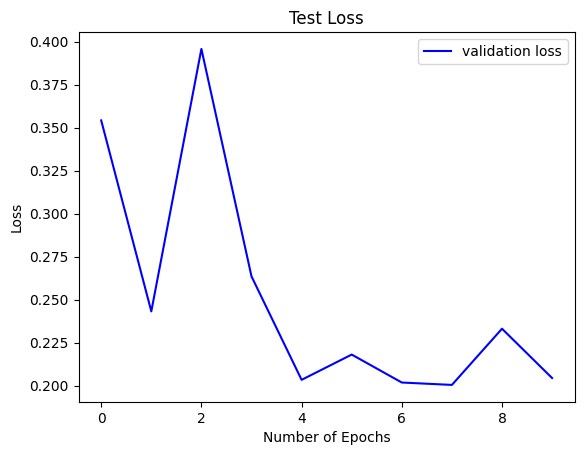

In [155]:
# Plot the loss and accuracy curves for training and validation 
from matplotlib import pyplot as plt

plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [157]:
model.evaluate(test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.9413 - loss: 0.2584


[0.3033377230167389, 0.9327957034111023]

In [158]:
prediction = model.predict(test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step


In [159]:
#get actual categories
import tensorflow as tf
true_categories = tf.concat([y for x, y in test_set], axis=0)

#get predicted categories
predicted_categories = tf.argmax(prediction, axis=1)

In [160]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
confusion_matrix(predicted_categories, true_categories)

Confusion Matrix


array([[ 7, 14, 14, 13, 11],
       [19, 26, 15, 19, 14],
       [10, 14, 15,  8, 15],
       [15, 14, 11, 16, 20],
       [13, 23, 10, 15, 21]])

In [184]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img

values = []
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

dirpath = '/kaggle/working/split_dataset/test/sunflowers'
for root, _, files in os.walk(dirpath):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            #print(file_path)
            
            test_image = load_img(file_path, target_size = (img_height, img_width, 3)) 
            test_image = image.img_to_array(test_image)
            test_image = np.expand_dims(test_image,axis = 0)
            test_image = keras.applications.xception.preprocess_input(test_image)
            result = model.predict(test_image)
            result = np.argmax(result)
            values.append(result)

for i in range(5):
    print(class_names[i], values.count(i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━